## Generate geoJSON files for contours of inundation map

## References

1. [Extracting contours](https://stackoverflow.com/questions/18304722/python-find-contour-lines-from-matplotlib-pyplot-contour)
2. [Python Path objects](https://matplotlib.org/api/path_api.html)
3. [Geojson package](https://pypi.org/project/geojson/)
4. [Python Path tutorial](https://matplotlib.org/users/path_tutorial.html)

### First import some necessary tools
Note: you'll need to install the geojson module to run this notebook. If you have pip you can simply run
>pip install geojson

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from ptha_paths import data_dir, events_dir
import sys, os
from matplotlib import _cntr as cntr
from geojson import MultiPolygon, Feature, FeatureCollection, dump

Assuming that top level of this repository is at: /Users/aengle/Desktop/tsunami-inundation/ptha_tutorial
    Python codes can be found in codes_dir = /Users/aengle/Desktop/tsunami-inundation/ptha_tutorial/PythonCode
    Data files can be found in data_dir = /Users/aengle/Desktop/tsunami-inundation/ptha_tutorial/DataFiles
    Results for each event can be found in events_dir = /Users/aengle/Desktop/tsunami-inundation/ptha_tutorial/DataFiles/Events


### Set parameters 

In [3]:
# Parameters
events = ['AASZa', 'AASZb', 'AASZc', 'AASZd', 'CSZa', 'CSZb', 'CSZc', 'CSZd', 'CSZe', \
              'CSZf', 'KmSZa', 'KrSZa', 'SChSZa', 'TOHa']     # The events to consider
num_levels = 3       # The number of levels to partition inundation into
zeta_level_values = [1e-3] + list(linspace(0.5,4.5,num_levels-1))

In [4]:
zeta_level_values

[0.001, 0.5, 4.5]

### Read in the topography data and compute zeta-clines

In [28]:
# Read in topography data:
nx = 250
ny = 250

fixed_grid_file = os.path.join(data_dir, 'MapsTopo', 'fixedgrid_xyB_small.npy')
d=load(fixed_grid_file)
x=d[:,0] - 360   # Longitudes
y=d[:,1]         # Latitudes
B=d[:,2]         # Bathymetry (topography in the absence of water)
topo = reshape(B, (nx,ny), order='F')
X = reshape(x, (nx,ny), order='F')  # X[0,0] is min long, X[-1, 0] is max long
Y = reshape(y, (nx,ny), order='F')  # Y[0,0] is min lat,  Y[0, -1] is max lat

In [14]:
# Loop over all events and compute zeta clines for each
# Collect zeta clines for each level in multi-polygon environments
for event in events:
    event_dir = os.path.join(events_dir, event)
    hmax_file = os.path.join(event_dir, 'h_eta_small.npy')
    hmax = load(hmax_file)
    Hmax = hmax.reshape((nx,ny),order='F')
    features = [None] * num_levels
    c = cntr.Cntr(X,Y,Hmax)
    for k in xrange(num_levels):
        # Go from largest values to smallest to get appropriate overlapping
        # contours = c.trace(zeta_level_values[num_levels-k-1])  # this returns paths and categorical variables. Separate..
        contours = c.trace(zeta_level_values[num_levels-k-1])  # this returns paths and categorical variables. Separate..
        num_paths = len(contours) // 2   # Half of the entries correspond to path connection types
        path_list = [poly.tolist() for poly in contours[:num_paths]]  # grab the first half
        multi_poly = MultiPolygon([path_list])
        features[num_levels-k-1] = Feature(geometry=multi_poly)
        
    feature_collection = FeatureCollection(features)
    json_file = os.path.join(event_dir, 'contours.geojson')
    
    # Write to a file using geojson dump in the events dir (see first cell of this notebook)
    with open(json_file, 'w') as outfile:
        dump(feature_collection,outfile)
    

# Everything below is experiments with contour plots in matplotlib.

In [81]:
from matplotlib import contour

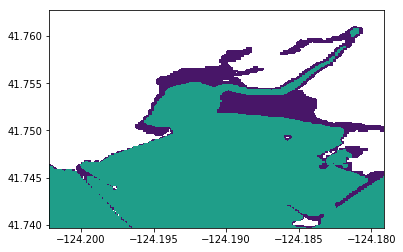

In [82]:
plt.contourf(X,Y,Hmax,zeta_level_values)

In [83]:
## example
xx = np.linspace(-1,1,nx)
XX = np.repeat(xx, nx).reshape(nx,ny)
YY = np.tile(xx, nx).reshape(nx,ny)
ZZ = XX**2 + YY**2
c = cntr.Cntr(XX, YY, ZZ)
contours = c.trace(0.5)  # the ZZ = 0.5 level-curve
num_paths = len(contours) // 2  # see this stackexchange link
# https://stackoverflow.com/questions/18304722/python-find-contour-lines-from-matplotlib-pyplot-contour

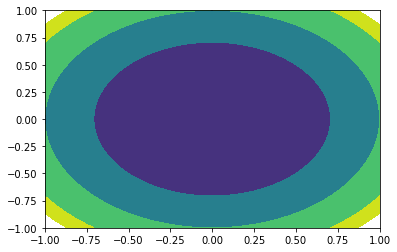

In [84]:
plt.contourf(XX,YY,ZZ,levels=[0,0.5,1,1.5,1.75])